# CNN-VAE on HUTUBS dataset (3D conv)

In [ ]:
%load_ext autoreload
%autoreload 2

In [48]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from IPython.display import display

from utils_data import load_hutubs_yamo
from utils_model import create_model_3d
from utils_train import train_model
from utils_plot import plot_latent_space, plot_latent_pairs, plot_reconstructions_3d, plot_reconstructions_3d_oh, plot_xcorr

## Load data

In [6]:
# show all possible setups
azimuths = sio.loadmat('./data/hutubs_hrtf/configs.mat')['azimuths'][0]
elevations = sio.loadmat('./data/hutubs_hrtf/configs.mat')['elevations'][0]
print(azimuths, '\n', elevations)
print(len(azimuths[::5]) * (len(elevations[::2])-2))

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355] 
 [-85 -80 -75 -70 -65 -60 -55 -50 -45 -40 -35 -30 -25 -20 -15 -10  -5   0
   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90]
240


In [70]:
np.arange(-45,46,5) % 360

array([315, 320, 325, 330, 335, 340, 345, 350, 355,   0,   5,  10,  15,
        20,  25,  30,  35,  40,  45])

In [71]:
# load HRTFs from HUTUBS 
filters = {
    'ears': ['left'],
    #'ids': range(1,31),
    'azimuths': np.arange(-45,46,5) % 360,
    'elevations': np.arange(-45,46,5)
}
(x_train, y_train), (x_test, y_test) = load_hutubs_yamo(
    dataset_path='./data/hutubs_hrtf/', 
    anthropometrics_path='./data/hutubs_measures.csv', 
    data_content='hrtfs',
    user_filters=filters)

# show resulting data shapes
print('train set:', x_train.shape)
print('test set: ', x_test.shape)

image_size = x_train.shape[1:]

  0%|          | 55/33573 [00:00<01:01, 548.00it/s]

Train/test split: 69/24 ids
361


100%|██████████| 33573/33573 [00:57<00:00, 586.43it/s]

train set: (24909, 5, 5, 128)
test set:  (8664, 5, 5, 128)


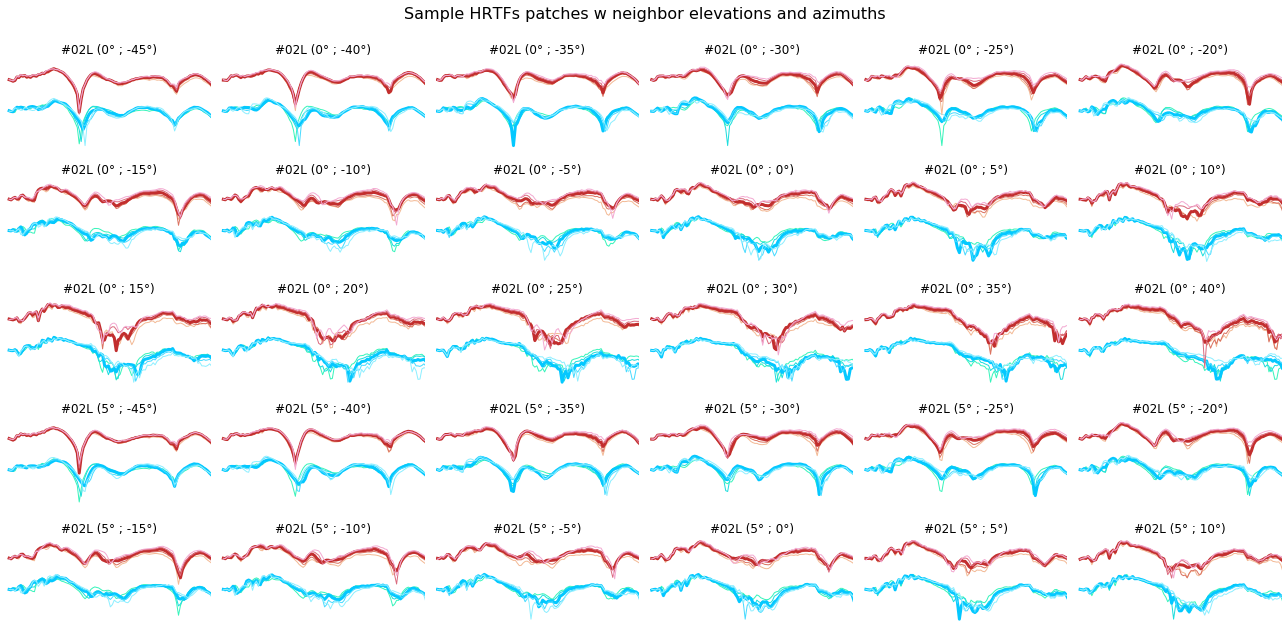

In [66]:
from matplotlib.colors import LinearSegmentedColormap
my_cmap1 = LinearSegmentedColormap.from_list('mycmap1', ['#45ffab', '#03c8ff', '#b0f8ff'])
my_cmap2 = LinearSegmentedColormap.from_list('mycmap2', ['#ffddb0', '#c22d2d', '#ffc9fa'])

nr, nc = 5, 6
w = 18
h = w / 2
f = sio.loadmat('./data/hutubs_hrtf/configs.mat')['f'][0]
offs = 30

fig, ax = plt.subplots(nr, nc, figsize=(w, h))
for i, a in enumerate(ax.flatten()):
    a.set_prop_cycle(c=[my_cmap1(i) for i in np.linspace(0.1, 0.9, 5)], lw=[1, 1, 3, 1, 1])
    a.plot(f, x_train[i, 0, :].T)
    a.set_prop_cycle(c=[my_cmap2(i) for i in np.linspace(0.1, 0.9, 5)], lw=[1, 1, 3, 1, 1])
    a.plot(f, x_train[i, :, 0].T + offs)
    a.set_title('#{:02}{} ({:.0f}° ; {:.0f}°)'.format(
            y_train['id'].iloc[i], y_train['ear'].iloc[i][0].upper(),
            y_train['azimuth'].iloc[i], y_train['elevation'].iloc[i]))    
    a.set_ylim([-40, 20+offs])
    a.set_xlim([0, 18000])
    a.axis('off')
fig.suptitle('Sample HRTFs patches w neighbor elevations and azimuths', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])


## Create network

In [37]:
# network parameters
modelname = '3d_2'
input_shape = image_size
filters_layers = [32, 16]
n_latent = 16
use_batchnorm = True

# create 3d-conv net
encoder, decoder, vae = create_model_3d(input_shape=input_shape, filters_layers=filters_layers, n_latent=n_latent)

# pre-compute some info for training
curr_epoch = 0
log_id = int(time.time()) % 99999999
tensorboard_destination = f'./logs/{log_id}'

batch_size = x_train.shape[0] // 8
#print(batch_size)

# store logs
logs_df = pd.read_pickle('./logs_3d.pkl')
logs_df.loc[log_id] = {
    'modelname': modelname,
    'input_shape': input_shape,
    'filters_layers': filters_layers,
    'kernel_size': np.nan,
    'n_latent': n_latent,
    'use_batchnorm': np.nan,
    'use_maxpool': np.nan,
    'freq_loss': np.nan,
    'date_time': datetime.datetime.now(),
    'batch_size': batch_size,
}
logs_df.to_pickle('./logs_3d.pkl')
display(logs_df.iloc[-5:])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 5, 5, 128)    0                                            
__________________________________________________________________________________________________
reshape_26 (Reshape)            (None, 5, 5, 128, 1) 0           encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_0_zpad (ZeroPadding3D)  (None, 5, 5, 130, 1) 0           reshape_26[0][0]                 
__________________________________________________________________________________________________
encoder_0_3dconv (Conv3D)       (None, 3, 3, 128, 32 864         encoder_0_zpad[0][0]             
__________________________________________________________________________________________________
encoder_0_

,modelname,input_shape,filters_layers,kernel_size,n_latent,use_batchnorm,use_maxpool,freq_loss,date_time,batch_size
log_id,,,,,,,,,,
72265524,3d_2,"(5, 5, 128)","[32, 16]",NaN,16,NaN,NaN,NaN,2019-10-28 13:25:09.909669,1104
72265720,3d_2,"(5, 5, 128)","[32, 16]",NaN,16,NaN,NaN,NaN,2019-10-28 13:28:25.587314,552
72267842,3d_2,"(5, 5, 128)","[32, 16]",NaN,16,NaN,NaN,NaN,2019-10-28 14:03:47.901973,276
72267915,3d_2,"(5, 5, 128)","[32, 16]",NaN,16,NaN,NaN,NaN,2019-10-28 14:05:00.835380,276
72268674,3d_2,"(5, 5, 128)","[32, 16]",NaN,16,NaN,NaN,NaN,2019-10-28 14:17:39.108103,276


## Train network

In [58]:
# training parameters
epochs = 500
validation_freq = 5
earlystopping_patience = -50
checkpoint_destination = None #'./models/{epoch.h5}'
cuda_device = '2'
tqdm_bar = True
# train the autoencoder
epochs_range = [curr_epoch, curr_epoch+epochs]
print(f'Training log: {tensorboard_destination}')
print(f'Training from {epochs_range[0]} to {epochs_range[1]}..')
trainig_history = train_model(vae, x_train, None, 
                              x_test, None, 
                              batch_size, epochs_range=epochs_range,
                              validation_freq=validation_freq,
                              tqdm_bar=tqdm_bar,
                              earlystopping_patience=earlystopping_patience, 
                              checkpoint_destination=checkpoint_destination, 
                              tensorboard_destination=tensorboard_destination, 
                              cuda_device=cuda_device)

curr_epoch += trainig_history.index[-1]

Training log: ./logs/72268674
Training from 398 to 898..


loss: 0.01: 100%|██████████| 500/500 [14:05<00:00,  1.69s/it]


## Plot results

minimum loss:  0.009665622375905514


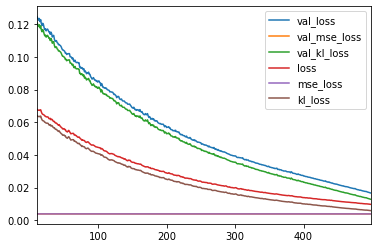

In [59]:
trainig_history.iloc[10:].plot()
print('minimum loss: ', trainig_history['loss'].min())

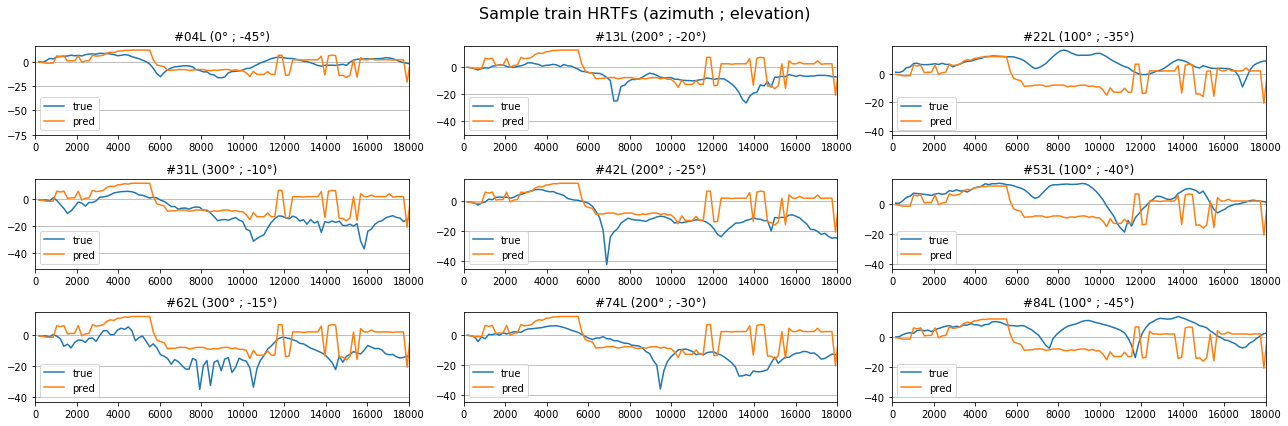

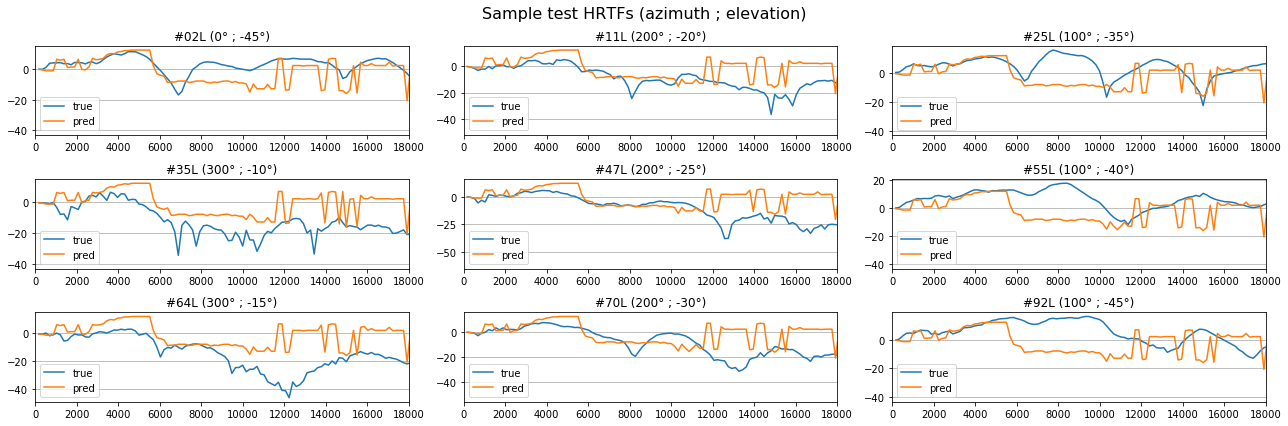

In [60]:
# take data
data_train = (x_train, y_train)
data_test = (x_test, y_test)

# plot reconstructions
fig, axs = plt.subplots(3, 3, figsize=(18, 6))
plot_reconstructions_3d_oh(encoder, decoder, data_train, axs=axs, batch_size=batch_size)
fig.tight_layout()
fig.suptitle('Sample train HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

fig, axs = plt.subplots(3, 3, figsize=(18, 6))
plot_reconstructions_3d_oh(encoder, decoder, data_test, axs=axs, batch_size=batch_size)
fig.tight_layout()
fig.suptitle('Sample test HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

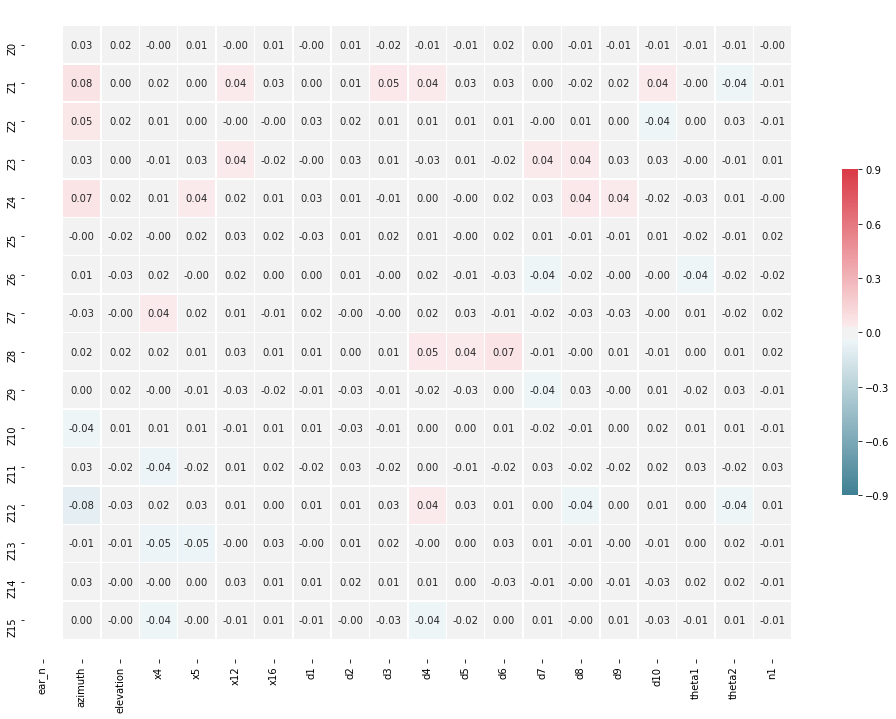

In [61]:
# data to use
drop_cols = ['ear', 'id', 'x6', 'x7', 'x8', 'x9', 'x14', 'x17', 'x2', 'x3', 'x1']
#data_train = (x_train, y_train.drop(columns=['elevation', 'azimuth', 'xoffs', 'yoffs', *drop_cols]).astype(float))
data_train = (x_train, y_train.drop(columns=drop_cols).astype(float))
data_test = (x_test, y_test.drop(columns=drop_cols).astype(float))

# plot correlation
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
plot_xcorr(encoder, data_train, ax,
           batch_size=batch_size, pca=False,
           labels=True)

In [ ]:
# plot PC
data_train = (x_train[::2], y_train['id'].iloc[::2])
data_test = (x_test, y_test['elevation'])
plot_latent_pairs(encoder, data_train,
                  batch_size=batch_size, n_pca=False, n_dim=6, plot_kws=dict(edgecolor='none', alpha=0.5, s=15))

In [ ]:
#data_train = (x_train, y_train['id'].astype('category').cat.codes)
#data_test = (x_test, y_test['id'].astype('category').cat.codes)
data_train = (x_train, y_train['d5'])

# plot latent dims
fig, axs = plt.subplots(2, n_latent//4, figsize=(14, 8))
combinations = np.arange(n_latent).reshape((n_latent//2, 2))
for i, dims in enumerate(combinations):
#for dims in [[14, 15]]:
    dims += 1
    plot_latent_space(encoder, data_train, axs.flatten()[i],
                      batch_size=batch_size, dims=dims,
                      colorbar=(i%4==3), use_pca=False)
fig.tight_layout()

In [ ]:
# TODO:
# - 3d plots
# - hyperparam opt: `talos`
# - noise solo a input
# - train con 'cubo' (elevation, azimuth, frequency) https://www.sciencedirect.com/science/article/pii/S0925231215014940
# - semisupervised learning http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/
# - inception layers (unabridged) https://becominghuman.ai/understanding-and-coding-inception-module-in-keras-eb56e9056b4b
# - plot: tsne on latent space
# - extract hrtf/hrir
# - plot: hrtf/hrir
# - freq_loss: pearson vs mse?
# - store and load trained model

# - spetral distortion (500, 16k) Hz (viking paper)

In [10]:
## NOTE: only run if there's no existing log file!
logs_df = pd.DataFrame(columns=[
    'modelname', 'input_shape', 'filters_layers', 
    'kernel_size', 'n_latent', 'use_batchnorm', 
    'use_maxpool', 'freq_loss', 'date_time'])
logs_df.index.name = 'log_id'
logs_df.to_pickle('./logs_3d.pkl')



In [65]:
xxx = x_train[0, 3, 3, :]
bins = np.linspace(-80, 20, 256)

yyy = np.digitize(xxx, bins)

In [ ]:
plt.figure(figsize=(18, 12))
plt.plot(f, (xxx-xxx.mean())/xxx.std())
plt.plot(f, (yyy-yyy.mean())/yyy.std())

In [47]:
from keras import backend as K


In [62]:
x = np.array([1,2,3,4,3,2,1,0,1,2,3,4,3,2,1,0])

In [64]:
-45 % 360

315